In [19]:
from __future__ import annotations
import math
from collections.abc import Iterable, Callable
from graphviz_plot import draw_dot

In [33]:
class Value:
    """
    what does single Value contains
    """

    def __init__(
        self, data, _children: Iterable | None = None, op="", label=""
    ) -> None:
        self.data = data
        self._prev = set(_children) if _children else set()
        self.grad: int | float = 0
        self._op = op
        self.label = label
        # its intresting to note backward will be called by output Value
        self._backward: Callable = lambda: None

    def __str__(self) -> str:
        return f"Label: {self.label} | Data:{self.data:.4f} | Grad:{self.grad:.4f}"
    
    def __repr__(self) -> str:
        return f"Label: {self.label} | Data:{self.data:.4f} | Grad:{self.grad:.4f}"
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __add__(self, other: Value | int | float) -> Value:

        if isinstance(other, int):
            other = Value(other)
        elif isinstance(other, float):
            other = Value(other)
        elif isinstance(other, Value):
            pass
        else:
            raise Exception("invalid type expected int or float")
        data = self.data + other.data
        out = Value(data, _children=(self, other), op="+")

        def _backward():
            # local derivative time global derivative
            # for addition local derivative will be 1
            # global derivate will be out.grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __radd__(self, val: int | float) -> Value:
        other = Value(val)
        data = self.data + other.data
        out = Value(data, _children=(self, other))

        def _backward():
            # local derivative time global derivative
            # for addition local derivative will be 1
            # global derivate will be out.grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other: Value | int | float) -> Value:
        if isinstance(other, int):
            other = Value(other)
        elif isinstance(other, float):
            other = Value(other)
        elif isinstance(other, Value):
            pass
        else:
            raise Exception("invalid type expected int or float")
        data = self.data * other.data
        out = Value(data, _children=(self, other), op="*")

        def _backward():
            # local derivative time global derivative
            # for multiplication local derivative will be other.data
            # global derivate will be out.grad
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, val: int | float) -> Value:
        other = Value(val)
        data = self.data * other.data
        out = Value(data, _children=(self, other), op="*")

        def _backward():
            # local derivative time global derivative
            # for multiplication local derivative will be other.data
            # global derivate will be out.grad
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data

        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, _children=(self,), op="tanh")

        def _backward():
            # local derivative time global derivative
            # for tanh local derivative will be 1-tanh2(x)
            # global derivate will be out.grad
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        val = self.data**other
        out = Value(val, _children=(self,), op=f"**{other}")
        
        def _backward():
            self.grad += (other * (self.data ** (other-1))) * out.grad
        
        out._backward = _backward
        return out
    
    def __rpow__(self, other):
        assert isinstance(other, (int, float))
        val = self.data**other
        out = Value(val, _children=(self,), op=f"**{other}")
        
        def _backward():
            self.grad += (other * (self.data ** (other-1))) * out.grad
        
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def exp(self):
        x = self.data

        out = Value(math.exp(x), (self,), op="exp")

        def _backward():
            # local derivative times global derivate
            # local derivative will be  math.exp(x)
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    @property
    def prev(self):
        """
        Getter property for protected variable _prev
        """
        return self._prev

    @property
    def op(self):
        """
        Getter for self._op
        """
        return self._op

    def backprop(self):
        """
        Backpropagate
        """
        self.grad = 1.0
        topo = []
        visited = set()

        def build_topo(node):
            if node in visited:
                return

            visited.add(node)
            for child in node.prev:
                build_topo(child)
            topo.append(node)

        build_topo(self)
        for node in reversed(topo):
            node._backward()

In [35]:
a = Value(2)
b = Value(4)

2**b

Label:  | Data:16.0000 | Grad:0.0000

In [23]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1.label = 'x1*w1'
x2w2.label = 'x2*w2'

x1w1_x2w2 = x1w1 + x2w2
x1w1_x2w2.label = 'x1*w1 + x2*w2'

n = x1w1_x2w2 + b
n.label = 'n'
o = n.tanh() ; o.label = 'o'

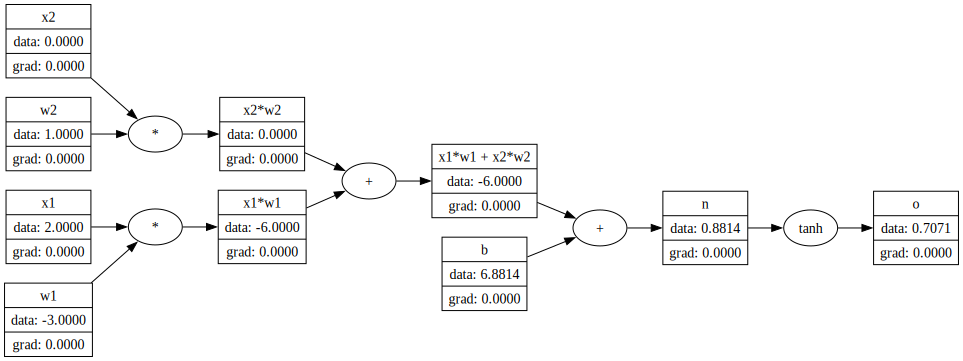

In [24]:
draw_dot(o)

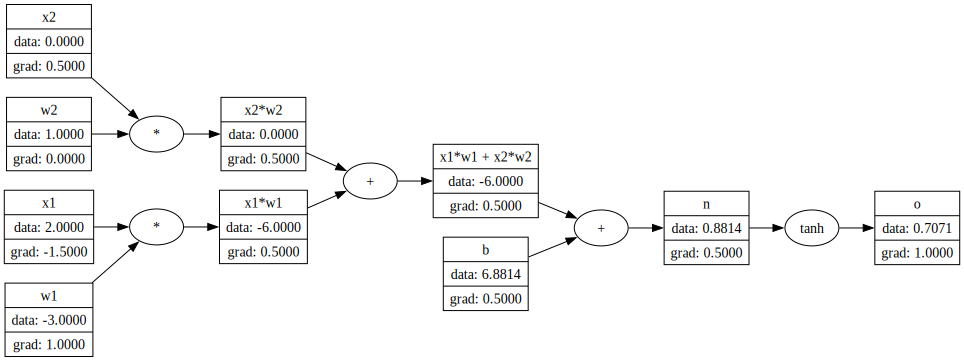

In [25]:
o.backprop()
draw_dot(o)